
# Evaluating Imputation in Proteomics Data using SoftImpute
This notebook demonstrates how to impute missing data in proteomics analyses using the SoftImpute method. The SoftImpute method is implemented in the Bystro software package, which functions similarly to the imputation methods found in scikit-learn. The process involves creating an imputation object and then using the fit_transform method to impute the missing values, which are represented by NaNs.


In [2]:

# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('/home/austin/Forks/bystro/python/python/bystro/imputation/fancyimpute/')
from soft_impute import SoftImpute

# Load the data

In [3]:
X = np.genfromtxt('/media/austin/ThickBoy__1/DataSynapse/Emory300_tmt_batch_blood_log2abundance.csv',
                  delimiter=',')
X = X[1:]
X = X[:,1:]


# Experimental Setup
In this experiment, we simulate missing data in a proteomics dataset by introducing NaNs with a certain probability using the `nan_with_probability` function. This function randomly replaces a specified percentage of the dataset's values with NaNs, simulating the kind of missing data often encountered in real-world proteomics analyses.

We know the true values of the omitted data, which allows us to evaluate the accuracy of the imputation by comparing the imputed values to the original ones. This is crucial for assessing how well the SoftImpute method performs in filling in missing data.

The goal of the experiment is to demonstrate how the SoftImpute method can be used to accurately impute these missing values and to evaluate the quality of the imputation.


In [4]:
def nan_with_probability(X, p):
    """
    Takes an input array X and a float p.
    Of the values in X that are not NaN, sets the elements to NaN with probability p.
    Returns the modified array X and a mask indicating which values were set to NaN.
    Parameters:
    - X: np.array, the input array possibly containing NaNs.
    - p: float, probability with which a non-NaN element of X is set to NaN.
    Returns:
    - X_modified: np.array, the modified array with additional NaNs.
    - mask: np.array, a boolean array where True indicates a value was set to NaN by this function.
    """
    # Create a mask of the same shape as X, initially all False
    mask = np.zeros(X.shape, dtype=bool)
    # Find indices of non-NaN values in X
    non_nan_indices = np.where(~np.isnan(X))
    # Generate random numbers for these indices
    random_numbers = np.random.rand(len(non_nan_indices[0]))
    # Determine which values to set to NaN based on probability p
    to_nan = random_numbers < p
    # Apply the decision to X and mask
    X[non_nan_indices[0][to_nan], non_nan_indices[1][to_nan]] = np.nan
    mask[non_nan_indices[0][to_nan], non_nan_indices[1][to_nan]] = True
    return X, mask

# Exploratory data analysis

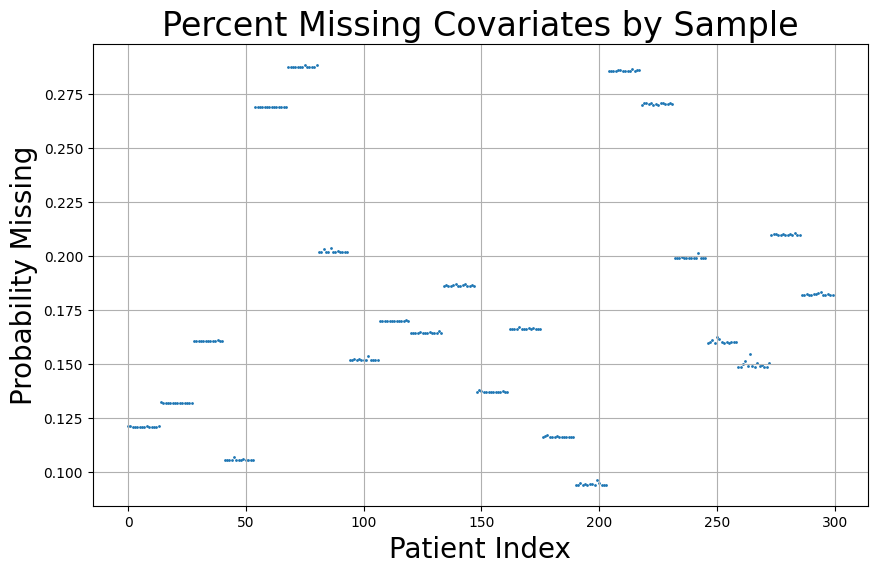

In [5]:

# Plot of Percent Missing Data by Patient
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(X.shape[1]),np.mean(np.isnan(X),axis=0), marker='o',s=1)
plt.title('Percent Missing Covariates by Sample', fontsize=24)
plt.xlabel('Patient Index',fontsize=20)
plt.ylabel('Probability Missing',fontsize=20)
plt.grid(True)
plt.show()


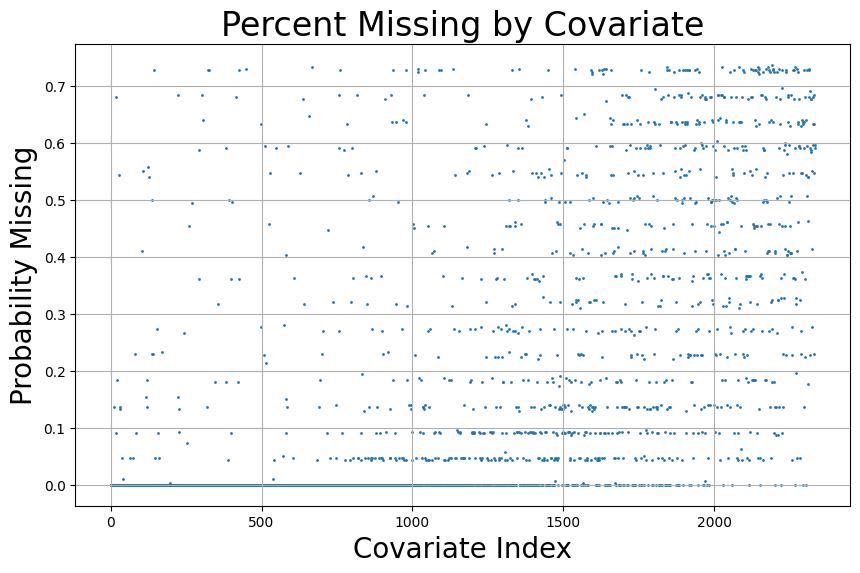

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(X.shape[0]),np.mean(np.isnan(X),axis=1), marker='o',s=1)
plt.title('Percent Missing by Covariate', fontsize=24)
plt.xlabel('Covariate Index',fontsize=20)
plt.ylabel('Probability Missing',fontsize=20)
plt.grid(True)
plt.show()



# Removing Data for Evaluation
For the purposes of evaluation in this demonstration, we are going to "remove" some of the data so we can evaluate the accuracy of the imputation. In a real analysis, this would not be done, but here it allows us to compare the imputed values to the true values and assess the performance of the imputation method.


In [7]:
X_modified, mask = nan_with_probability(X.copy(), .05)

# Steps for Imputing Missing Data with SoftImpute

### 1. Creating a SoftImpute Object
In Bystro (or similarly in scikit-learn), the first step is to choose the SoftImpute method for imputing missing data. SoftImpute is a technique that fills in missing values by finding a low-rank approximation of the data matrix. You create an object of SoftImpute by calling its class, like `imputer = SoftImpute()`. This object is now ready to learn how to fill in the missing data.

### 2. Imputing Missing Data Using the `fit_transform()` Method
Once you have your SoftImpute object, the next step is to impute the missing data. This is where the model looks at the incomplete data and tries to estimate the missing values. You do this by calling the `fit_transform()` method on your SoftImpute object and passing in the data with missing values. For example, `imputed_data = imputer.fit_transform(data)`. During this step, SoftImpute analyzes the data and fills in the gaps by approximating the data matrix. It’s like teaching the imputer to guess the missing values based on the available information.

### 3. Using the Imputed Data
After the `fit_transform()` method has been applied, you get back a complete data matrix where the missing values have been filled in. This imputed data can now be used for further analysis, modeling, or any other data processing tasks.

### Putting It All Together
The process with SoftImpute is straightforward:

- **Create**: You start by creating a SoftImpute object that will handle the imputation.
- **Fit and Transform**: You then fill in the missing data by using the `fit_transform()` method, where SoftImpute learns from the data and fills in the missing values.
- **Use**: Finally, you can use the fully imputed data for your subsequent analyses.


In [8]:
training_options = {"n_iterations": 10000}
model = SoftImpute(training_options=training_options)
X_complete_si = model.fit_transform(X_modified)

  5%|██                                     | 524/10000 [00:14<04:21, 36.19it/s]



# Evaluating the Imputation Accuracy
To evaluate the imputation accuracy, we'll use the Mean Squared Error (MSE) metric, which measures the average squared difference between the true values and the imputed values. A lower MSE indicates better accuracy.

We'll also compare the MSE of the SoftImpute method against a baseline, where we simply guess the mean of the observed values. This baseline gives us a sense of how well SoftImpute performs relative to a very basic guess.


In [9]:
vals_imputed_si = X_complete_si[mask]
vals_original = X[mask]

random_guess_mse = np.mean((vals_original-np.mean(vals_original))**2)
si_mse = np.mean((vals_original-vals_imputed_si)**2)
print('Random guessing: ',random_guess_mse)
print('Soft Impute: ',si_mse)
print('Variance Explained: ',1-si_mse/random_guess_mse)


Random guessing:  0.3335403896611994
Soft Impute:  0.10272142132944638
Variance Explained:  0.6920270392626577
